This notebook aims to assess the generalization accuracy of a generated suffix, assuming a data-split was used during training.

In [18]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from transformers import AutoTokenizer
import pandas as pd
import seaborn as sns
from types import SimpleNamespace
from datasets import Dataset
from os.path import join as oj
import pickle as pkl
import os
import dvu
dvu.set_style()
import analyze_utils
import sys
sys.path.append('..')
import data
from model_utils import prompt_classification

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the results + get generated suffixes

In [19]:
# # NOTE: SAVED THIS TO A DIFFERENT DIR!!!!
# results_acc_dir = oj('/home/chansingh/interpretable-autoprompting/results/generalization_acc/accs_sent_rerun')
# accs = [
#     pd.DataFrame.from_dict(pkl.load(open(oj(results_acc_dir, d), 'rb')))
#     for d in os.listdir(results_acc_dir)
# ]
# df = pd.concat(accs)
# df['max_digit'] = df['max_digit'].fillna(10)
# df = df.drop_duplicates()

# # extract acc since gpt3 func returns a tuple
# def extract_acc(x):
#     if isinstance(x, tuple):
#         return x[1]
#     else:
#         return x
# df.acc = df.acc.apply(extract_acc)

In [20]:
# df.to_pickle('../results/autoprompt_sentiment/sent_ood_results.pkl')

In [ ]:
df = pd.read_pickle('../results/autoprompt_sentiment/sent_ood_results.pkl')

In [3]:
task_names_sentiment = ['ffb_train', 'imdb_train', 'rt_train', 'sst2_train']
d = df[(df.task_name.isin(task_names_sentiment))]

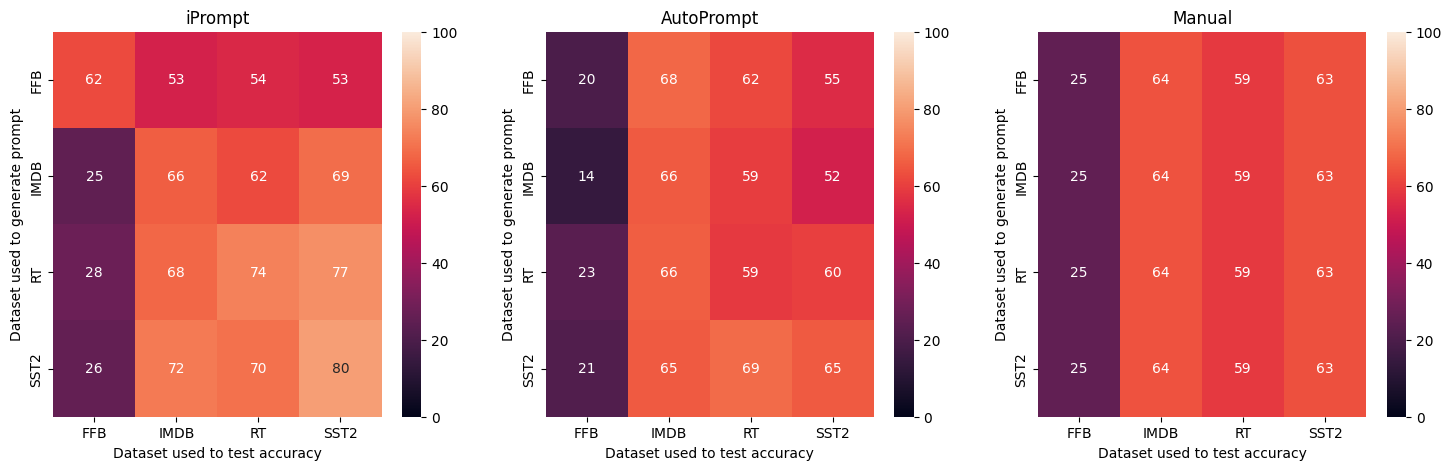

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
accs_list = []
for idx, method in enumerate(['iprompt', 'autoprompt', 'manual']):
    d = df[(df.task_name.isin(task_names_sentiment)) & \
        (df.prompt == method) & \
            (df.checkpoint == 'EleutherAI/gpt-j-6B') & \
                (df.prompt_seed == 1)]
    accs = np.zeros((len(task_names_sentiment), len(task_names_sentiment)))
    for i, task_name_prompt in enumerate(task_names_sentiment):
        for j, task_name_test in enumerate(task_names_sentiment):
            acc = d[(d.task_name == task_name_test) & (d.task_name_prompt == task_name_prompt)].acc
            # print(acc.size)
            accs[i, j] = acc #.max()
    accs_list.append(deepcopy(accs))
    # plt.imshow(accs)
    ax = axes[idx]
    sns.heatmap(accs, vmin=0, vmax=100, ax=ax, annot=True)
    def clean_lab(dset):
        return dset.replace('_train', '').upper()
    labs = [clean_lab(lab) for lab in task_names_sentiment]
    ax.set_xticks(np.arange(len(task_names_sentiment)) + 0.5, labels=labs)
    ax.set_yticks(np.arange(len(task_names_sentiment)) + 0.5, labels=labs)
    ax.set_ylabel('Dataset used to generate prompt')
    ax.set_xlabel('Dataset used to test accuracy')
    # plt.colorbar(label='Test accuracy', vmin=0, vmax=100)
    ax.set_title({
        'iprompt': 'iPrompt',
        'autoprompt': 'AutoPrompt',
        'manual': 'Manual'
    }[method])
plt.savefig('../results/autoprompt_sentiment/sent_vary_test_dset.pdf', bbox_inches='tight')

<AxesSubplot:>

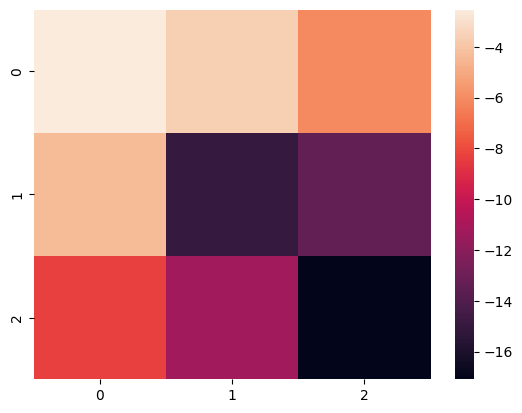

In [12]:
sns.heatmap((accs_list[2] - accs_list[0])[1:, 1:])